In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random
import warnings
from minepy import cstats
from autots import AutoTS, load_daily
import warnings
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from dotenv import dotenv_values
import numpy as np
import cx_Oracle
import warnings
from matplotlib.dates import DateFormatter
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from itertools import product
warnings.filterwarnings('ignore')  # .filterwarnings(action='once') 
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
seed=42
random.seed(seed)
test_size=20
sep="!"
n_iter = 10
cv = 5

In [ ]:
# config = dotenv_values("../../../.env")
# out_db_params = {
#     'db_host': config["ORACLE_IP"],
#     'db_name': config["ORACLE_DB"],
#     'db_user': config["ORACLE_USER"],
#     'db_password': config["ORACLE_PWD"],
#     'db_port': config["ORACLE_PORT"]
# }
# print(config["LD_LIBRARY_PATH"])
# cx_Oracle.init_oracle_client(lib_dir=config["LD_LIBRARY_PATH"])
# engine = create_engine('oracle+cx_oracle://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'.format(**out_db_params))
# query = "SELECT * FROM cimice_dt_time"
# df = pd.read_sql(query, engine)
# df

Get the query

In [ ]:
def get_data(columns=None, filters=None, file_name=None):
    df = pd.read_csv(file_name) # esempio external knowledge
    if columns is not None: df = df[columns]
    if filters is not None:
        for column, predicates in filters.items():
            df = df[df[column].apply(lambda x: x in predicates)].reset_index(drop=True)
    if "week_in_year" in list(df.columns):
        df["week_in_year"] = pd.to_datetime(df['week_in_year'] + '-1', format='%Y-%W-%w') 
    return df
df = get_data(columns=["province", "week_in_year", "adults", "small_instars", "total_captures"], filters={'province': ['BO', 'RA']}, file_name='cimice-filled.csv') # esempio interest

In [ ]:
def compute_mic(data, casualty_var):
    """
    Compute the MIC matrix for the given data
    :param data: input data
    :param casualty_var: casualty variables to consider
    :return: the MIC matrix
    """
    X1 = data.dropna().reset_index()[casualty_var]
    X1.columns = casualty_var
    X = X1
    X = X.transpose()
    mic_c, tic_c = cstats(X, X, alpha=9, c=5, est="mic_e")
    xs = casualty_var
    ys = casualty_var
    mic_c = pd.DataFrame(mic_c, index=ys, columns=xs)
    return mic_c

# compute_mic(df, [target_measure] + values)

Decision tree (without time handled separatedly)

In [ ]:
def compute_model(df, target_column, model, seed=seed, test_size=test_size):
    df_enc = df.copy(deep=True)
    # One-hot encode object columns
    object_columns = list(df.select_dtypes(include=['object']).columns)
    if len(object_columns) > 0: df_enc = pd.get_dummies(df_enc, drop_first=True, dtype=float, prefix_sep=sep)
    # Convert data columns to float
    datetime_columns = list(df_enc.select_dtypes(include=['datetime64']).columns)
    if len(datetime_columns) > 0: df_enc[datetime_columns] = df_enc[datetime_columns].astype('int64') / 10**9
    # Create a separate dataframe for rows with missing values in the target column
    missing_values_df = df_enc[df_enc[target_column].isnull()]
    if len(missing_values_df) == 0: return df, df[target_column], None, None, None, None, None, None, None
    df_enc = df_enc.dropna(subset=[target_column])
    # Separate target variable (what you want to predict) from features
    X = df_enc.drop(target_column, axis=1)
    y = df_enc[target_column]
    # Split the data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=False)
    X_train, y_train, X_test, y_test = X[:-test_size+1], y[:-test_size+1], X[-test_size:], y[-test_size:]
    model.fit(X_train, y_train)
    # Get the best parameters and the best model
    # best_params = model.best_params_
    # best_model = model.best_estimator_
    # print('Best Hyperparameters:', best_params)
    y_pred = model.predict(X_test)
    value = r2_score(y_test, y_pred)    
    # Fill in missing values in the original dataframe
    missing_values_df[target_column] = model.predict(missing_values_df.drop(target_column, axis=1))
    df.loc[df[target_column].isnull(), target_column] = missing_values_df[target_column]
    return df, df[target_column], X_train, y_train, X_test, y_test, y_pred, missing_values_df, value


def dtree(df, target_column, date_attr=None, seed=seed, test_size=test_size):
    # Define the hyperparameters you want to search through
    param_grid = {
        'max_depth': [2, 3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [seed] 
    }
    model = RandomizedSearchCV(DecisionTreeRegressor(random_state=seed), param_grid, n_iter=n_iter, cv=cv, scoring='r2', random_state=seed)
    return compute_model(df, target_column, model)

# X, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = dtree(df.copy(deep=True), target_measure)

In [ ]:
def forest(df, target_column, date_attr=None, seed=seed, test_size=test_size):
    # Define hyperparameters to tune and their possible values
    param_grid = {
        'n_estimators': [2, 3, 4, 5],
        'max_depth': [2, 3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [seed] 
    }
    model = RandomizedSearchCV(RandomForestRegressor(random_state=seed), param_grid, n_iter=n_iter, cv=cv, scoring='r2', random_state=seed)
    return compute_model(df, target_column, model)

# X, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = forest(df.copy(deep=True), target_measure)

In [61]:
def mypivot(df, date_attr, column, exog, target_measure, impute=False):
    if column is not None:
        # pivot on a single column, if you want to pivot on multiple columns merge them into a single one. Necessary for melting the dataframe later
        df = df.pivot_table(index=date_attr, columns=[column], values=exog, dropna=False)
        df.columns = [f'{col[0]}{sep}{col[1]}' if col[1] else col[0] for col in df.columns]
        df = df.reset_index()
    else:
        df.columns = [f'{x}{sep}ALL' if x != date_attr else x for x in df.columns]
    if impute:
        for x in [x for x in df.columns if target_measure not in x and df[x].isnull().any()]:
            df[x] = df[x].fillna(method='ffill').fillna(method='bfill') # df[x].fillna(df[x].median()) #  
    return df[[x for x in df.columns if "index" not in x]]

def melt(df, date_attr, column, target_measure):
    if column is not None:
        df = df[[x for x in df.columns if sep not in x or target_measure in x]]
        df = pd.melt(df, id_vars=date_attr, value_vars=[x for x in df.columns if target_measure in x], var_name=column, value_name=target_measure)
        df[column] = df[column].apply(lambda x: x.replace(f"{target_measure}{sep}", ""))
    return df

def plot(fig, axs, cdf, date_attr, target_measure, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value, i=0, figtitle=''):
    # fig.suptitle("" + figtitle + "")
    # fig.autofmt_xdate()
    axs[i].plot(cdf[date_attr].loc[X_train.index], y_train, label="Train", c='blue')
    axs[i].plot(cdf[date_attr].loc[X_test.index], y_test, label="Test", c='blue', ls='--')
    if y_pred is not None:
        axs[i].plot(cdf[date_attr].loc[X_test.index], y_pred, label="Pred", c='darkorange', ls='--')
    
    axs[i + 1].plot(cdf[date_attr], y, c='blue')
    axs[i + 1].scatter(cdf[date_attr].loc[missing_values_df.index], missing_values_df[target_measure], label="Pred", c='darkorange')
    axs[i + 1].set_xlim([cdf[date_attr].tail(20).min(), cdf[date_attr].tail(20).max()])
    
    for j in range(2):
        title = f'{target_measure.split(sep)[1]}' + (f' (R$^2$={max(0.0, round(value, 2))})' if j == 0 else '') 
        myFmt = DateFormatter("%Y-%W")
        axs[i + j].tick_params(axis='x', rotation=45)
        axs[i + j].xaxis.set_major_formatter(myFmt)
        axs[i + j].set_title(title)
        axs[i + j].set_xlabel('$\\sf{' + date_attr.replace("week_in_year", "week") + '}$')
        axs[i + j].set_ylabel('$\\sf{' + target_measure.split(sep)[0].replace('avg', '') + '}$')
        axs[i + j].grid()
        # if i == 0:
        #     # axs[i + j].legend(ncol=3)
        #     if j == 0:
        #         axs[i + j].legend(bbox_to_anchor=(0, 1.18, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
        #     else:
        #         axs[i + j].legend(bbox_to_anchor=(0.35, 1.18, 0.3, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
    fig.tight_layout()

def save(fig, figtitle, target_measure):
    fig.tight_layout()
    for ext in ["svg", "pdf"]: fig.savefig(f"{figtitle}_{target_measure}.{ext}")
    

def timeseries(df, date_attr, column, target_measure, model, figtitle="dt", test_size=test_size):
    targets = [x for x in df.columns if sep in x and target_measure in x]
    actual_targets = [c for c in targets if df[c].isnull().any()]
    fig, axs = plt.subplots(len(actual_targets), 2, figsize=(8, 1 + 3*len(actual_targets)), sharex=False, sharey=False)  # Create a figure and subplots
    axs = axs.flatten()  # Flatten the axs array if it's a multi-dimensional array
    i = 0
    for c in actual_targets:
        cdf = df.drop(columns=[x for x in targets if x != c], axis=1)  # drop the wrong target measures 
        cdf = df.drop(columns=[x for x in df.columns if sep in x and c.split(sep)[1] not in x], axis=1)  # drop the wrong slices 
        cdf, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = model(cdf, c, date_attr=date_attr, test_size=test_size)  # compute the model
        plot(fig, axs, cdf, date_attr, c, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value, i, figtitle)
        i += 2
        save(fig, figtitle, c)
    return melt(df, date_attr, column, target_measure)

In [62]:
import pandas as pd
def sarimax(df, target_measure, date_attr, test_size=test_size, seed=seed):
    # Create a separate dataframe for rows with missing values in the target column
    mydf = df
    missing_values_df = df[df.isnull().any(axis=1)]
    missing_indices = missing_values_df.index
    df = df.dropna()
    exog = [x for x in df.columns if target_measure.split(sep)[0] not in x and x != date_attr]
    X_train, y_train, X_test, y_test = df[exog][:-test_size+1], df[target_measure][:-test_size+1], df[exog][-test_size:], df[target_measure][-test_size:]
    param_space = {
        'p1': [1, 2, 3],
        'p2': [1, 2, 3],
        'p3': [1, 2, 3],
        'p4': [1, 2, 3],
        'p5': [1, 2, 3],
        'p6': [1, 2, 3],
        'p7': [4, 7, 12],
    }
    best_r2, best_hp, best_y_pred = float('-inf'), {}, None
    random.seed(seed)
    for _ in range(min(len(list(product(*param_space.values()))), n_iter)):
        try:
            # Generate a random set of hyperparameters
            c_hp = {hp: random.choice(values) for hp, values in param_space.items()}
            # Train and evaluate the model with the current set of hyperparameters
            order = (c_hp["p1"] , c_hp["p2"], c_hp["p3"]) # to tune 
            seasonal_order = (c_hp["p4"], c_hp["p5"], c_hp["p6"], c_hp["p7"]) # to tune
            model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
            results = model.fit(iterations=100, disp=False)
            y_pred = results.get_forecast(steps=test_size, exog=X_test).predicted_mean
            y_pred.index = y_test.index
            c_r2 = r2_score(y_test, y_pred)
            # Update the best hyperparameters if the current configuration is better
            if c_r2 > best_r2:
                best_r2 = c_r2
                best_hp = dict(c_hp)
                best_y_pred = y_pred
        except Exception as e:
            print(f"sarimax({c_hp}) - training: {e}")
    
    try:
        order = (best_hp["p1"], best_hp["p2"], best_hp["p3"])
        seasonal_order = (best_hp["p4"], best_hp["p5"], best_hp["p6"], best_hp["p7"])
        model = SARIMAX(endog=df[target_measure], exog=df[exog], order=order, seasonal_order=seasonal_order)
        results = model.fit(iterations=100, disp=False)
        forecast = results.get_prediction(start=missing_indices[0], end=missing_indices[-1], exog=mydf[exog].loc[missing_indices]).predicted_mean
        forecast.index = mydf.loc[missing_indices[0]:missing_indices[-1]].index
        missing_values_df[target_measure] = forecast
        mydf.loc[mydf[target_measure].isnull(), target_measure] = missing_values_df[target_measure]
    except Exception as e:
        print(f"sarimax({c_hp}) - training: {e}")
        
    return mydf, mydf[target_measure], X_train, y_train, X_test, y_test, best_y_pred, missing_values_df, best_r2

In [63]:
def varmax(df, date_attr, target_measure, test_size=test_size):
    # Create a separate dataframe for rows with missing values in the target column
    exog = [x for x in df.columns if target_measure.split(sep)[0] not in x and x != date_attr]
    endo = [x for x in df.columns if target_measure in x]
    print(f"Exogeneous: {exog}, Endogeneous: {endo}")
    mydf = df
    all_values = df
    missing_indices = df[df.isnull().any(axis=1)].index
    df = df.dropna()
    X_train, Y_train, X_test, Y_test = df[exog][:-test_size+1], df[endo][:-test_size+1], df[exog][-test_size:], df[endo][-test_size:]
    Y_pred = None
    param_space = {
        'p1': [1, 2, 3],
        'p2': [1, 2, 3]
    }
    best_r2, best_hp, best_Y_pred = float('-inf'), {}, None
    random.seed(seed)
    for _ in range(min(len(list(product(*param_space.values()))), n_iter)):
        try:
            # Generate a random set of hyperparameters
            c_hp = {hp: random.choice(values) for hp, values in param_space.items()}
            model = VARMAX(endog=Y_train, exog=X_train, order=(c_hp["p1"], c_hp["p2"]))
            results = model.fit(iterations=100, disp=False)
            fcst = results.get_forecast(steps=test_size, exog=X_test)
            Y_pred = fcst.predicted_mean
            Y_pred.index = Y_test.index
            c_r2 = r2_score(Y_test, Y_pred)
            # Update the best hyperparameters if the current configuration is better
            if c_r2 > best_r2:
                best_r2 = c_r2
                best_hp = dict(c_hp)
                best_Y_pred = Y_pred
        except Exception as e:
            print(f"varmax({c_hp}) - training: {e}")
    try:
        c_hp = best_hp
        model = VARMAX(endog=df[endo], exog=df[exog], order=(best_hp["p1"], best_hp["p2"]))
        results = model.fit(iterations=100, disp=False)
        forecast = results.get_prediction(start=missing_indices[0], end=missing_indices[-1], exog=mydf[exog].loc[missing_indices]).predicted_mean
        forecast.index = all_values.loc[missing_indices[0]:missing_indices[-1]].index
        all_values[endo] = all_values[endo].fillna(forecast)
    except Exception as e:
        print(f"varmax({c_hp}) - predicting: {e}")
    return mydf, mydf[endo], X_train, Y_train, X_test, Y_test, best_Y_pred, forecast.loc[missing_indices], best_r2

In [64]:
def multi_timeseries(df, date_attr, column, target_measure, model, figtitle, test_size=test_size):
    targets = [x for x in df.columns if sep in x and target_measure in x]
    fig, axs = plt.subplots(len(targets), 2, figsize=(8, 1 + 3*len(targets)), sharex=False, sharey=False)  # Create a figure and subplots
    axs = axs.flatten()  # Flatten the axs array if it's a multi-dimensional array
    i = 0
    df, Y, X_train, Y_train, X_test, Y_test, Y_pred, missing_values_df, value = model(df, date_attr, target_measure, test_size=test_size)
    for c in targets:
        plot(fig, axs, df, date_attr, c, Y[c], X_train, Y_train[c], X_test, Y_test[c], Y_pred[c], missing_values_df, value, i, figtitle)
        i += 2
        save(fig, figtitle, c)
    return melt(df, date_attr, column, target_measure)


# adf = multi_timeseries(mydf, date_attr, column, target_measure, varmax, figtitle="multivariateTS")

In [65]:
def predict(df, by, target_measure, nullify_last=None):
    date_attr = [x for x in by if "week" in x or "date" in x or "month" in x or "year" in x]
    if len(date_attr) == 0:
        date_attr = None
    else:
        date_attr = date_attr[0] # keep only one date attribute
    column = [x for x in by if x != date_attr]
    if len(column) == 0:
        column = None
    else:
        column = column[0]
    values = [x for x in df.columns if x not in by] # [target_measure, date_attr]
    print(f"date_attr: {date_attr}, column: {column}, values: {values}")
    if date_attr is not None:
        pdf = mypivot(df.copy(deep=True), date_attr, column, values, target_measure, impute=True)
        if nullify_last is not None:
            for x in [x for x in pdf.columns if target_measure in x]:
                for i in range(nullify_last): pdf.loc[len(pdf) - (i + 1), x] = np.nan
        # pdf.info()
        test_size = round(len(pdf) * 0.2)
        timeseries(pdf.copy(deep=True), date_attr, column, target_measure, sarimax, figtitle="univariateTS", test_size=test_size)
        timeseries(pdf.copy(deep=True), date_attr, column, target_measure, forest, figtitle="timeRandomForest", test_size=test_size)
        timeseries(pdf.copy(deep=True), date_attr, column, target_measure, dtree, figtitle="timeDecisionTree", test_size=test_size)
        if column is not None and df[column].nunique() > 1:
            multi_timeseries(pdf, date_attr, column, target_measure, varmax, figtitle="multivariateTS", test_size=test_size)
    test_size = round(len(df) * 0.2)
    _, _, _, _, _, _, _, _, value = dtree(df.copy(deep=True), target_measure, test_size=test_size)
    print(f"decisionTree. R2={value}")
    _, _, _, _, _, _, _, _, value = forest(df.copy(deep=True), target_measure, test_size=test_size)
    print(f"randomForest. R2={value}")

date_attr: week_in_year, column: None, values: ['avgadults', 'avgsmall_instars', 'avgcum_degree_days']
decisionTree. R2=0.5899238053722228
randomForest. R2=0.60719118004656


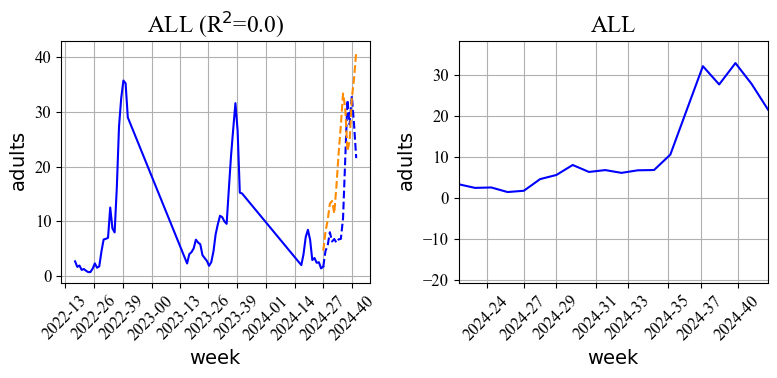

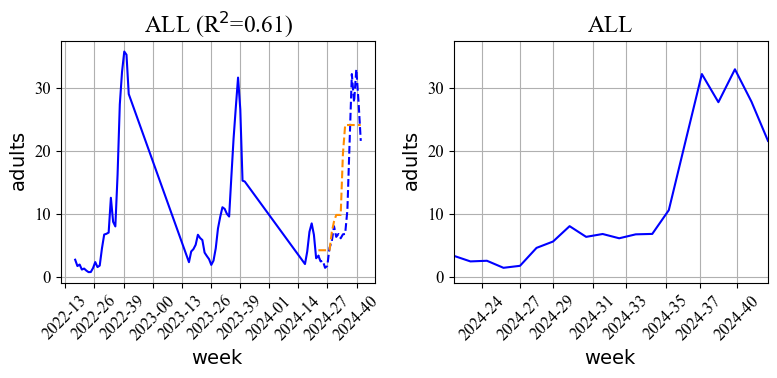

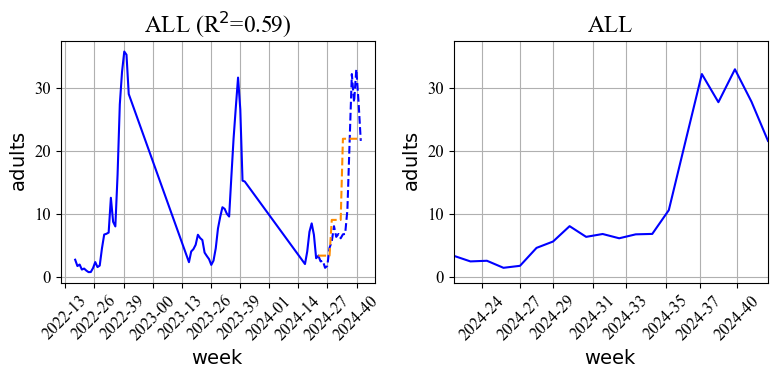

In [66]:
df = get_data(columns=["week_in_year", "avgadults", "avgsmall_instars", "avgcum_degree_days"], file_name='cimice-week.csv')
predict(df, ["week_in_year"], "avgadults", nullify_last=0)

date_attr: week_in_year, column: None, values: ['avgadults', 'avgsmall_instars']
decisionTree. R2=-0.33233677446638366
randomForest. R2=0.07445524225593536


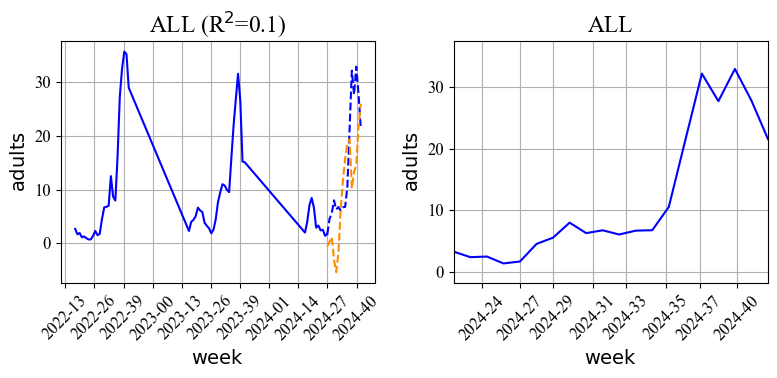

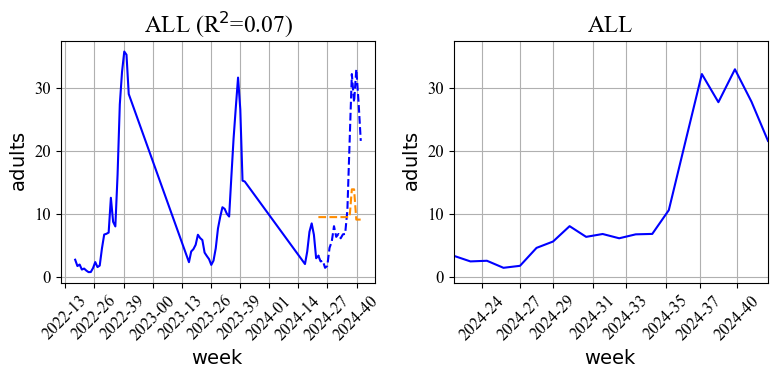

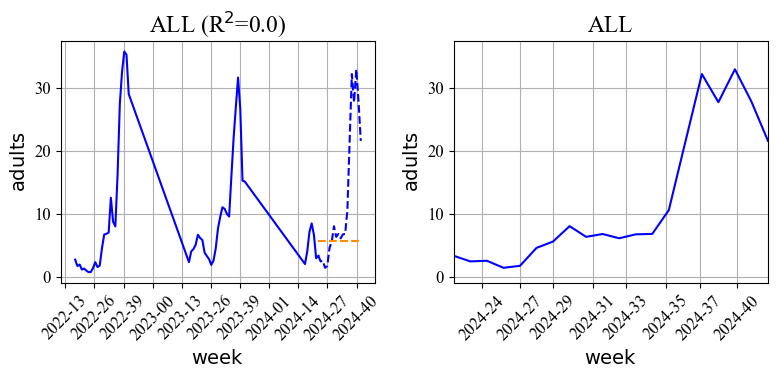

In [67]:
df = get_data(columns=["week_in_year", "avgadults", "avgsmall_instars"], file_name='cimice-week.csv')
predict(df, ["week_in_year"], "avgadults", nullify_last=0)

date_attr: week_in_year, column: province, values: ['adults', 'small_instars', 'total_captures']
sarimax({'p1': 1, 'p2': 3, 'p3': 1, 'p4': 3, 'p5': 3, 'p6': 3, 'p7': 4}) - training: LU decomposition error.
Exogeneous: ['small_instars!BO', 'small_instars!RA', 'total_captures!BO', 'total_captures!RA'], Endogeneous: ['adults!BO', 'adults!RA']
decisionTree. R2=0.9512480116417436
randomForest. R2=0.8635765201359809


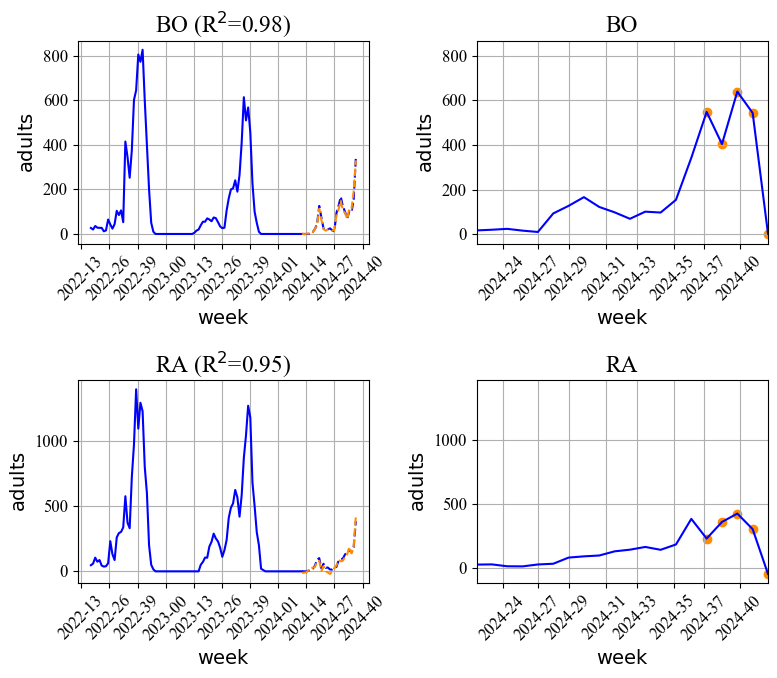

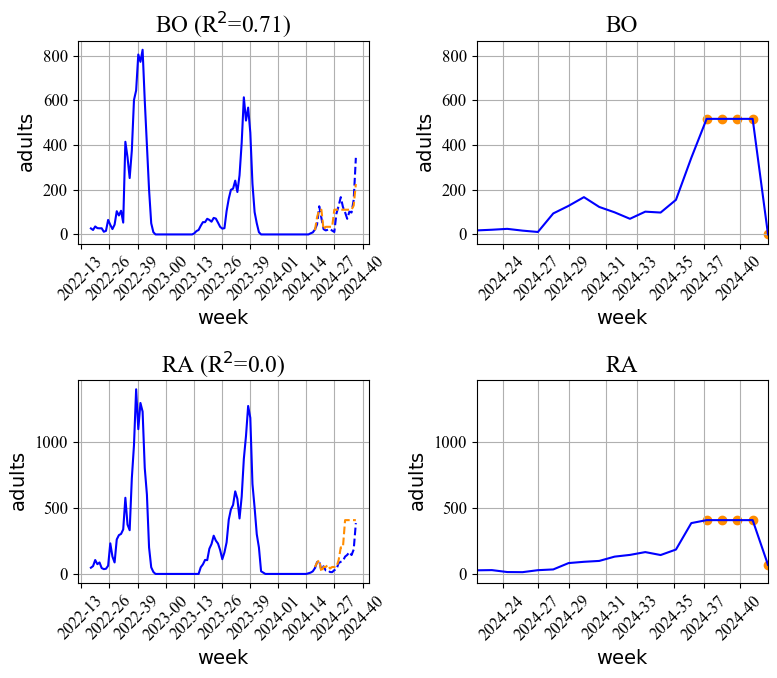

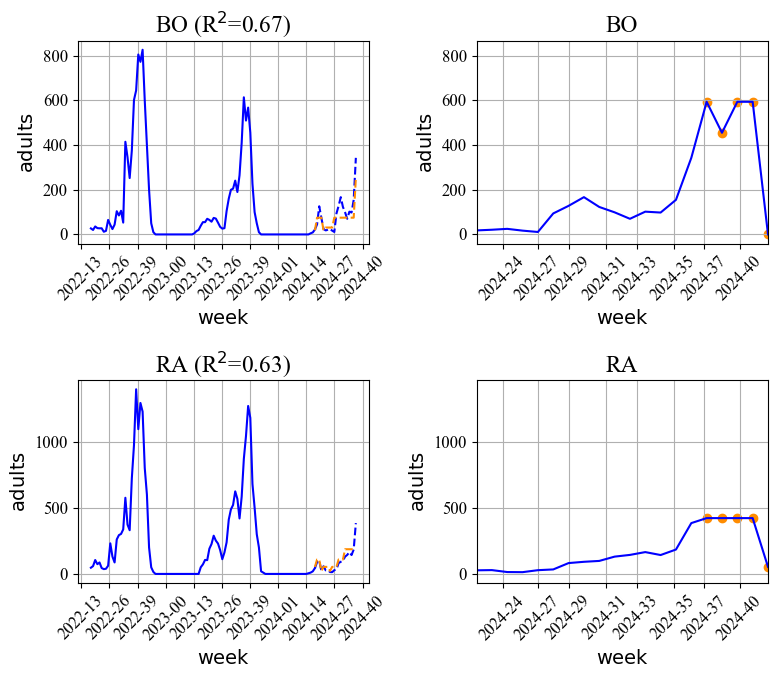

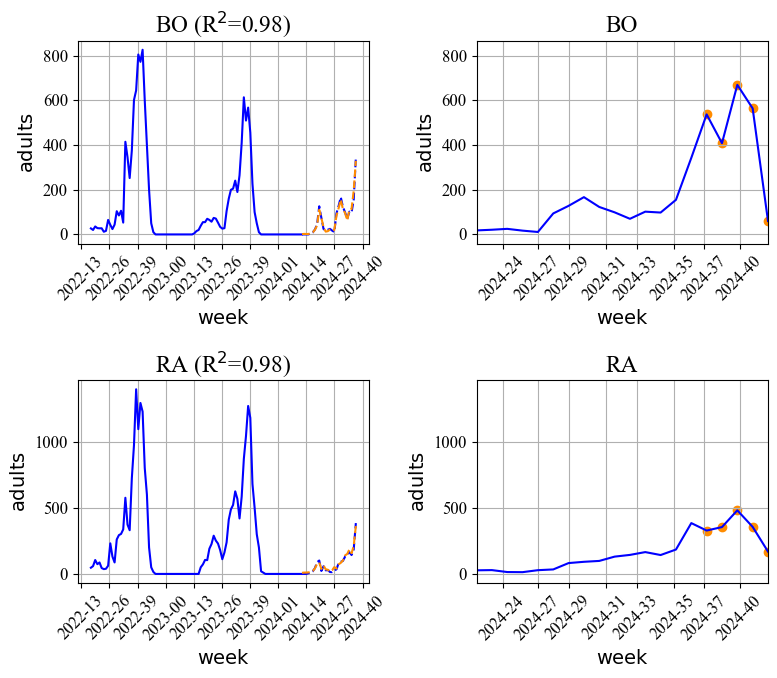

In [68]:
df = get_data(columns=["week_in_year", "province", "adults", "small_instars", "total_captures"], filters={'province': ['BO', 'RA']}, file_name='cimice-filled.csv')
predict(df, ["week_in_year", "province"], "adults", nullify_last=5)

date_attr: week_in_year, column: province, values: ['adults', 'small_instars', 'total_captures']
decisionTree. R2=0.8191985046908732
randomForest. R2=0.907231323808922


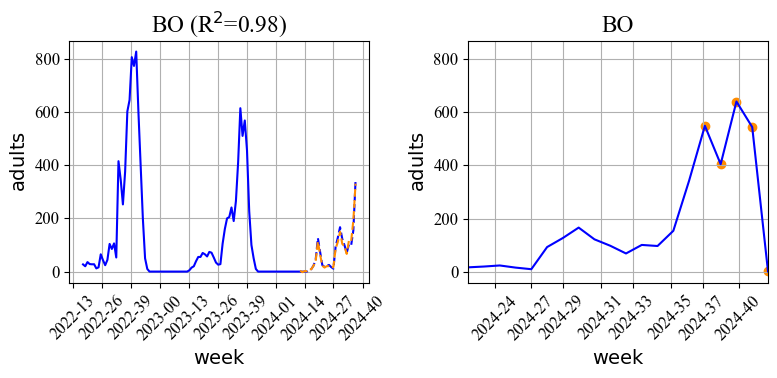

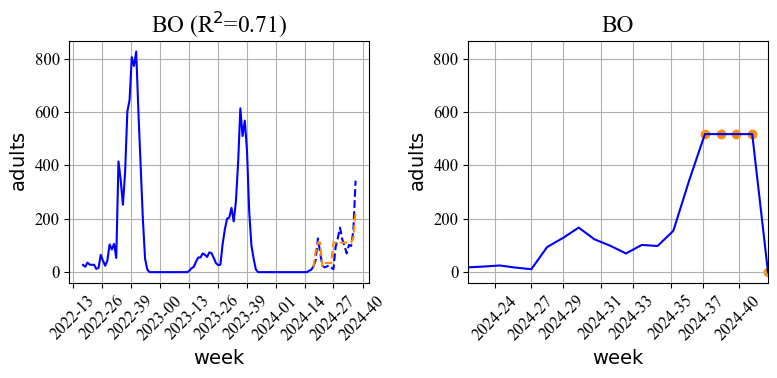

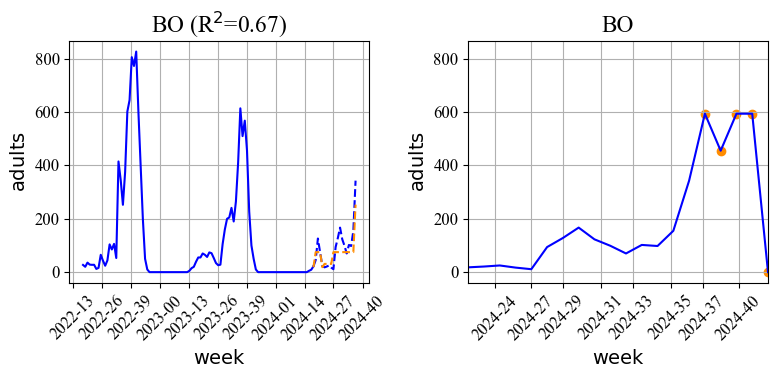

In [69]:
df = get_data(columns=["week_in_year", "province", "adults", "small_instars", "total_captures"], filters={'province': ['BO']}, file_name='cimice-filled.csv')
predict(df, ["week_in_year", "province"], "adults", nullify_last=5)